# Задача $P | r_j | L_{max}$

In [189]:
import json
import time
import glob
import math
import copy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.chebyshev as cheb
from scipy.stats import moment
from itertools import permutations
from ipywidgets import IntProgress
from scipy.interpolate import lagrange
from IPython.display import display
from IPython.display import clear_output


In [222]:
timeout = 120
LAMBDA = 0.01
MU = 100
SIGMA = 40
VARK = 1

def r(task):
    ind = 0
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def p(task):
    ind = 1
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def d(task):
    ind = 2
    if isinstance(task, TaskSet):
        return task.array[ind]
    return task[ind]

def remove(arr, elem):
    return np.delete(arr, np.where(np.in1d(arr, elem)))

class TaskSet:
    
    def __init__(self, a):
        if isinstance(a, int):
            rs = np.cumsum(np.random.exponential(scale=1/LAMBDA, size=(a,)))
            ps = np.clip(np.random.normal(MU, SIGMA, size=(a,)), a_min=0, a_max=None)
            ds = [r + VARK*moment(ps, moment=2) for r in rs]
            self.array = np.array([rs, ps, ds]).T.astype(float)
        else:
            self.array = np.copy(a)
            
    def __repr__(self):
        return "  r  |  p  |  d  \n" + str(self.array)
    
    def copy(self):
        return TaskSet(self.array)
    
    def __getitem__(self, key):
        return TaskSet(self.array[key])
    
    def __iter__(self):
        return iter(self.array)
    
    def C(self, i, tau=0):
        t = tau
        for task in self.array[:i+1]:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def C_max(self, tau=0):
        t = tau
        for task in self.array:
            if t < r(task): t = r(task)
            t += p(task)
        return t
    
    def L(self, i=None, tau=0):
        if i is None:
            return self.C_max(tau) - d(self[-1])
        return self.C(i, tau) - d(self[i])
    
    def L_max(self, tau=0):
        if len(self) == 0: return float('inf')
        return max([self.L(i, tau) for i, _ in enumerate(self)])
    
    def T(self, i=None, tau=0):
        return max(0, self.L(i, tau))
    
    def T_max(self, tau=0):
        return max(0, self.L_max(tau))
    
    def __len__(self):
        return len(self.array)
    
    def __eq__(self, other):
        return self.array == other
    
    def without(self, indexes):
        return TaskSet(np.delete(self.array, np.array(indexes).astype(float), axis=0))
    
    def find(self, item):
        return np.where((self.array == item).all(axis=1))[0]
    
    def transpose(self):
        return self.array.T
    
    def scale_r(self, alpha):
        self.array[:,0] = self.array[:,0]*alpha
        return self


In [21]:
# Функция поиска работы с наилучшим значением L_max
def find_local_best(s, sortedTasks, unsortedTasks):
    
    def find_L_max(task):
        pi = sortedTasks + [task]
        return s[pi].L_max()

    return min(unsortedTasks, key=find_L_max)

### "Жадный" алгоритм v1
Выбирает каждый раз работу с наилучшим значением $L_{max}$ для расписания каждой машины

In [170]:
# m is the num of machines
def greedy_Lmax(s, m):
    bestLmax = float('inf')
    piArray = [[] for i in range(m)]
    unsortedTasks = [i for i in range(len(s))]
    
    for i in range(len(s)):
        localPiArray = copy.deepcopy(piArray)
        bestLmax = float('inf')
        for j in range(m):
            sortedTasks = piArray[j]
            bestTask = find_local_best(s, sortedTasks, unsortedTasks)
            localPiArray[j] += [bestTask]
            currLmax = s[localPiArray[j]].L_max()
            if currLmax < bestLmax:
                bestLmax = currLmax
                bestj = j
                globalBestTask = bestTask
        piArray[bestj] += [globalBestTask]
        unsortedTasks.remove(globalBestTask)
    return bestLmax, piArray

### "Жадный" алгоритм v2
Выбирает каждый раз работу с наименьшим моментом поступления и ставит её в расписание той машины, для которой значение $L_{max}$ будет наименьшим.
**Спойлер:** оказался намного точнее. Возможно, дело в способе генерации примеров?..

In [167]:
def greedy_r(s, m):
    bestLmax = float('inf')
    piArray = [[] for i in range(m)]
    unsortedTasks = [i for i in range(len(s))]
    for i in unsortedTasks:
        localPiArray = copy.deepcopy(piArray)
        bestLmax = float('inf')
        for j in range(m):
            localPiArray[j].append(i)
            Lmax = s[localPiArray[j]].L_max()
            if Lmax < bestLmax:
                bestLmax = Lmax
                bestj = j
        piArray[bestj].append(i)
    return max([s[pi].L_max() for pi in piArray if len(pi) > 0]), piArray

### Перебор всех вариантов (для двух машин)

In [97]:
def bruteforce(s):
    bestPi1 = []
    bestPi2 = []
    pi = [i for i in range(len(s))]
    bestLmax = float('inf')
    for perm in permutations(pi):
        for i in range(len(s)+1):
            pi1 = perm[:i]
            pi2 = perm[i:]
            #print(pi1, pi2)
            if len(pi1) == 0:
                tLmax = s[list(pi2)].L_max()
            elif len(pi2) == 0:
                tLmax = s[list(pi1)].L_max()
            else:
                tLmax = max(s[list(pi1)].L_max(), s[list(pi2)].L_max())
            if tLmax < bestLmax:
                bestLmax = tLmax
                bestPi1 = list(pi1).copy()
                bestPi2 = list(pi2).copy()
    return bestLmax, bestPi1, bestPi2

In [174]:
# To test each of the greedy algs
def brute_test(func, N_TASKS=100):
    results = []
    pBar = IntProgress(min=0, max=N_TASKS)
    display(pBar)
    for i in range(N_TASKS):
        s = TaskSet(5)
        gL = func(s, 2)[0]
        bL = bruteforce(s)[0]
        if gL < bL:
            #print("Smth wrong with bruteforce")
            raise RuntimeError("Smth wrong with bruteforce")
        results.append((gL - bL)/np.abs(bL)*100)
        pBar.value += 1
    return pd.DataFrame([[max(results), min(results), np.mean(results)]], columns=["Максимум отклонения, %", "Минимум отклонения, %", "Среднее отклонение, %"])


### Тестирование жадного алгоритма v1

In [175]:
brute_test(greedy_Lmax)

IntProgress(value=0)

,"Максимум отклонения, %","Минимум отклонения, %","Среднее отклонение, %"
0,1839.977821,0.0,100.120743


### Тестирование жадного алгоритма v2

In [176]:
brute_test(greedy_r)

IntProgress(value=0)

,"Максимум отклонения, %","Минимум отклонения, %","Среднее отклонение, %"
0,6.467389,0.0,0.197566


# Зависимость значения $L_{max}$ от коэф-та $\alpha$ для разного кол-ва параллельных машин
(**Кол-во работ в расписании:** 50)

## Интерполяция Лагранжа

IntProgress(value=0, max=21)

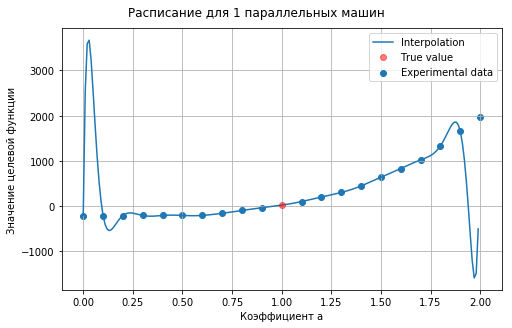

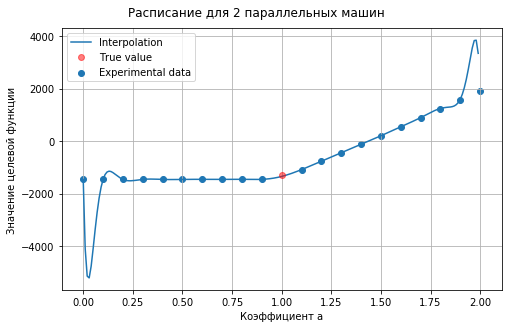

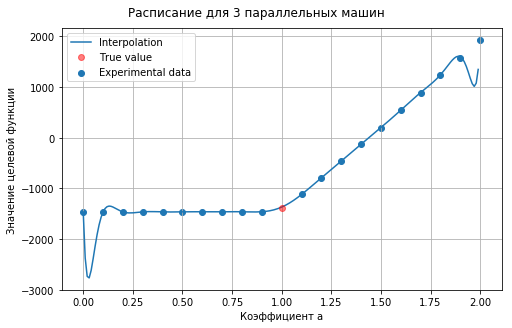

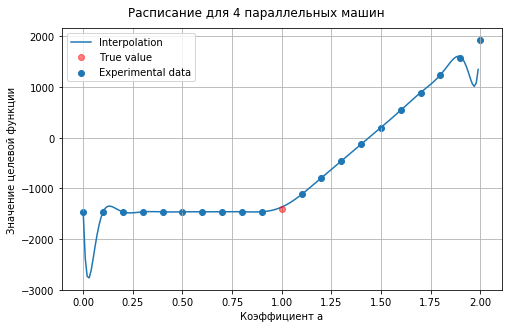

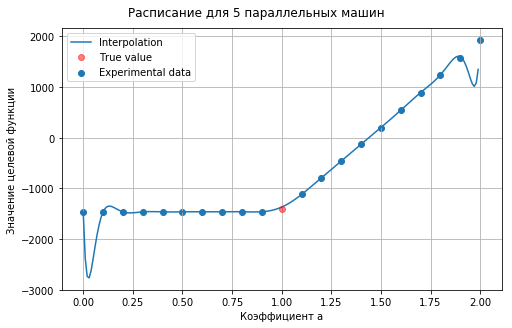

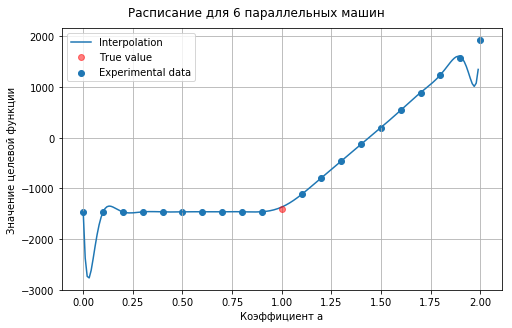

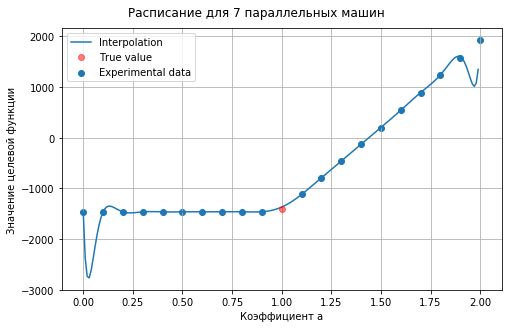

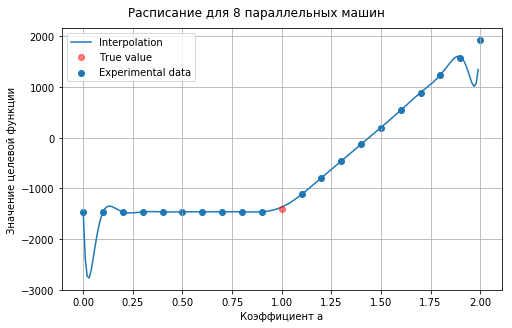

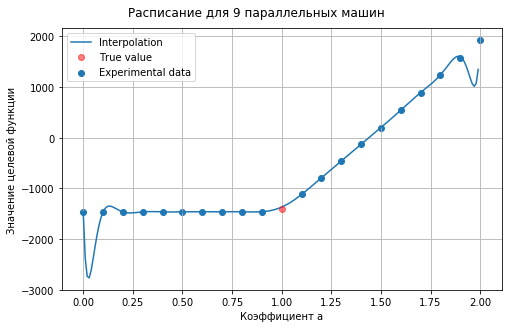

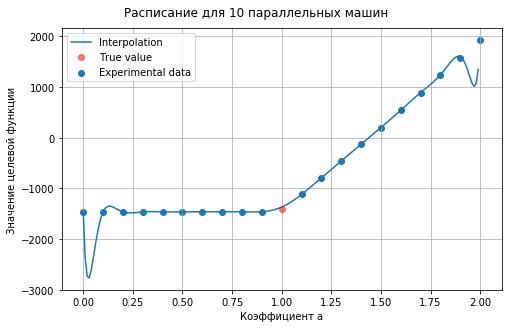

In [195]:
#alphaRange = remove(np.arange(0, 2, 0.1), 1.)
alphaRange = np.arange(0, 2.1, 0.1)
N_TASKS = 10

s = TaskSet(50)
prgBar = IntProgress(min = 0, max = len(alphaRange))
display(prgBar)
for n in range(N_TASKS):
    prgBar.value = 0
    m = n + 1
    scaledSchedules = []
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale_r(alpha))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    
    #print("\rCurrently working with", n)
    approxResults = []
    if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
    for i, a in enumerate(alphaRange):
        Lmax = greedy_r(scaledSchedules[i], m)[0]
        prgBar.value = prgBar.value + 1
        approxResults.append((a, Lmax))
    approxResults = np.array(approxResults)
    trueIndex = np.where(np.isclose(approxResults[:,0], 1.))[0]
    if trueIndex: 
        trueIndex = trueIndex[0]
        trueValue = approxResults[trueIndex]
        approxResults = np.delete(approxResults, trueIndex, axis=0)
    x = approxResults[:,0]
    y = approxResults[:,1]
    #print(x, y)
    poly = lagrange(x, y)
    xp = np.arange(x[0], x[-1], 0.01)
    yp = poly(xp)
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
    fig.suptitle("Расписание для %s параллельных машин" % m)
    axes.scatter(x, y, label="Experimental data")
    axes.plot(xp, yp, label="Interpolation")
    axes.grid()
    axes.set_xlabel("Коэффициент а")
    axes.set_ylabel("Значение целевой функции")
    axes.plot(1., trueValue[1], 'ro', label="True value", alpha=0.5)
    axes.legend()

## Интерполяция Чебышева

In [251]:
# использование глобальных переменных - костыль для передачи доп. аргументов в функцию интерполяции
global realResult
global approxResults
global m
global s
def test_schedule(alpha_arr):
    global approxResults
    global realResult
    global m
    global s
    approxResults = []
    for a in alpha_arr:
        #print("\ra =", a, end='')
        scaled_s = s.copy().scale_r(a)
        #flattenedScaled_s = list(map(lambda x: x.array.flatten(), scaled_s))
        Lmax = greedy_r(scaled_s, m)[0]
        approxResults.append((a, Lmax))
    realResult = (1., greedy_r(s, m)[0])
    approxResults = np.array(approxResults)
    return approxResults[:,1]

IntProgress(value=0, max=10)

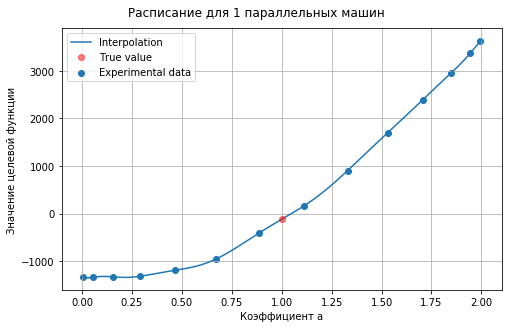

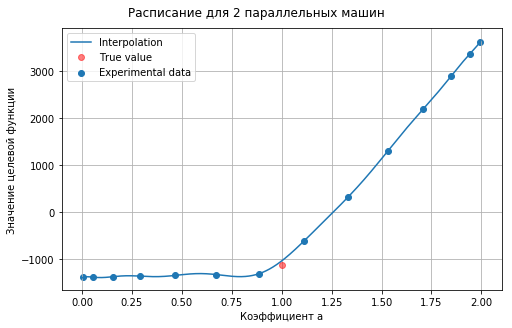

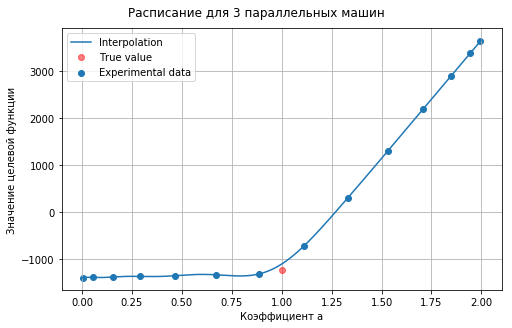

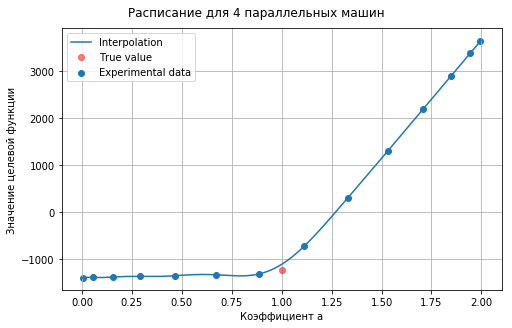

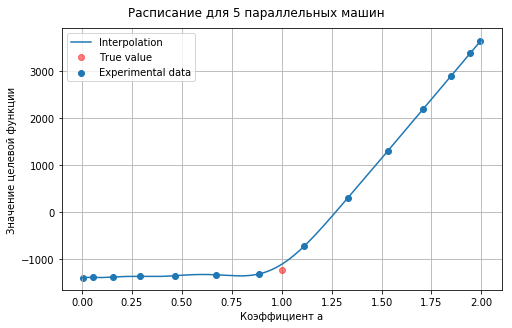

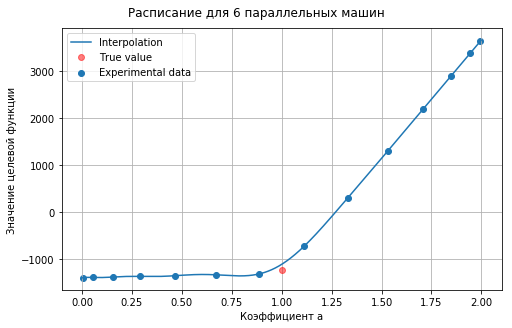

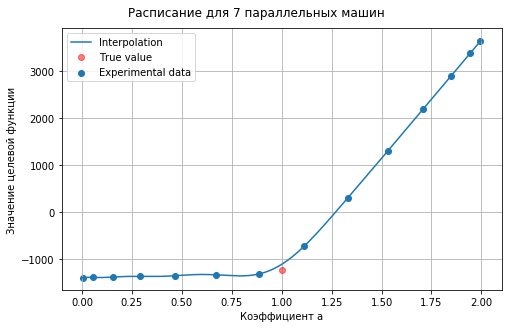

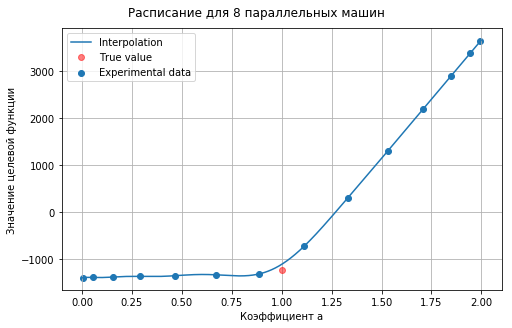

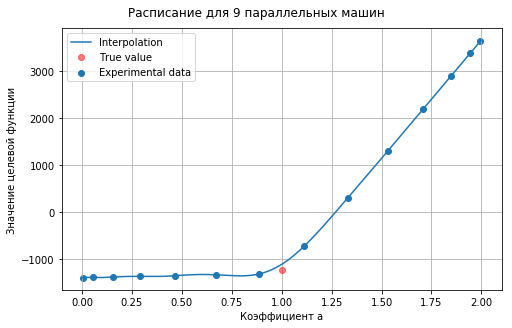

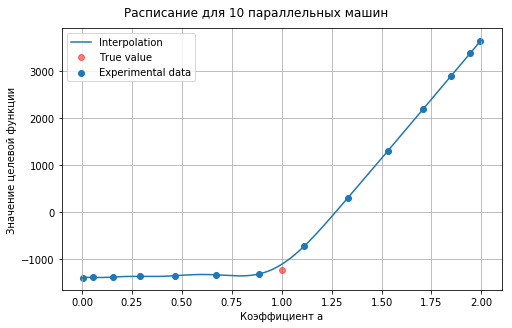

In [183]:
global realResult
global approxResults
global m
global s
s = TaskSet(50)

N_TASKS = 10
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
for i in range(N_TASKS):
    m = i + 1
    C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
    approxResults = np.array(approxResults)
    
    x = approxResults[:,0]
    y = approxResults[:,1]
    xp = np.arange(0, 2, 0.001)
    yp = C(xp)
    
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 4.5), constrained_layout=True)
    fig.suptitle("Расписание для %s параллельных машин" % m)
    axes.scatter(x, y, label="Experimental data")
    axes.plot(xp, yp, label="Interpolation")
    axes.grid()
    axes.set_xlabel("Коэффициент а")
    axes.set_ylabel("Значение целевой функции")
    axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
    axes.legend()
    pBar.value += 1

# Зависимость ошибки интерполяции от числа машин

In [256]:
N_TASKS = 50
prgBar = IntProgress(min=0, max=N_TASKS)
display(prgBar)
#global realResult
#global approxResults
#global s
#global m
globalResults = []
for n in range(N_TASKS):
    s = TaskSet(50)
    prgBar.value += 1
    scaledSchedules = []
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale_r(alpha))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    results = []
    for m in range(1, 17, 2):
        #print("\rCurrently working with", n)
        approxResults = []
        if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
        for i, a in enumerate(alphaRange):
            Lmax = greedy_r(scaledSchedules[i], m)[0]
            approxResults.append((a, Lmax))
        approxResults = np.array(approxResults)
        trueIndex = np.where(np.isclose(approxResults[:,0], 1.))[0]
        if trueIndex: 
            trueIndex = trueIndex[0]
            trueValue = approxResults[trueIndex]
            approxResults = np.delete(approxResults, trueIndex, axis=0)
        x = approxResults[:,0]
        y = approxResults[:,1]
        #print(x, y)
        poly = lagrange(x, y)
        results.append((poly(1.) - trueValue[1])/trueValue[1]*100)
    globalResults += [results]
with open("greedyMultipleLagrange.json", 'w') as f:
    json.dump(globalResults, f)

IntProgress(value=0, max=50)

## Интерполяция Лагранжа
(Два графика: эксп. точки с разным шагом)

In [255]:
N_TASKS = 25
prgBar = IntProgress(min=0, max=N_TASKS)
display(prgBar)
#global realResult
#global approxResults
#global s
#global m
globalResults = []
for n in range(N_TASKS):
    s = TaskSet(80)
    prgBar.value += 1
    scaledSchedules = []
    for alpha in alphaRange:
        scaledSchedules.append(s.copy().scale_r(alpha))
    flattenedScaledSchedules = list(map(lambda x: x.array.flatten(), scaledSchedules))
    results = []
    for m in range(1, 11, 1):
        #print("\rCurrently working with", n)
        approxResults = []
        if len(alphaRange) != len(scaledSchedules): raise RuntimeError()
        for i, a in enumerate(alphaRange):
            Lmax = greedy_r(scaledSchedules[i], m)[0]
            approxResults.append((a, Lmax))
        approxResults = np.array(approxResults)
        trueIndex = np.where(np.isclose(approxResults[:,0], 1.))[0]
        if trueIndex: 
            trueIndex = trueIndex[0]
            trueValue = approxResults[trueIndex]
            approxResults = np.delete(approxResults, trueIndex, axis=0)
        x = approxResults[:,0]
        y = approxResults[:,1]
        #print(x, y)
        poly = lagrange(x, y)
        results.append((poly(1.) - trueValue[1])/trueValue[1]*100)
    globalResults += [results]
with open("greedyMultipleLagrange-minscale.json", 'w') as f:
    json.dump(globalResults, f)

IntProgress(value=0, max=25)

**Размерность расписания:** 80

**Количество машин:** от 1 до 10 с шагом 1

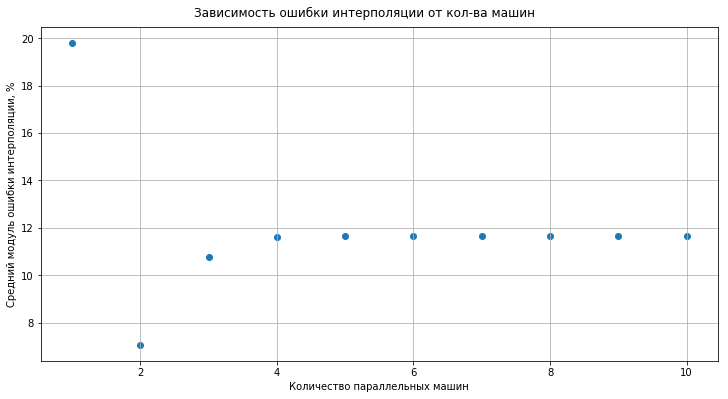

In [264]:
with open("greedyMultipleLagrange-minscale.json", 'r') as f:
    globalResults = json.load(f)
globalResults = np.array(globalResults).T
x = []
y = []
for i, res in enumerate(globalResults):
    x.append(i + 1)
    y.append(np.mean(np.abs(res)))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от кол-ва машин")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Количество параллельных машин")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()
pBar.value += 1

**Размерность расписания:** 50

**Количество машин:** от 1 до 15 с шагом 2

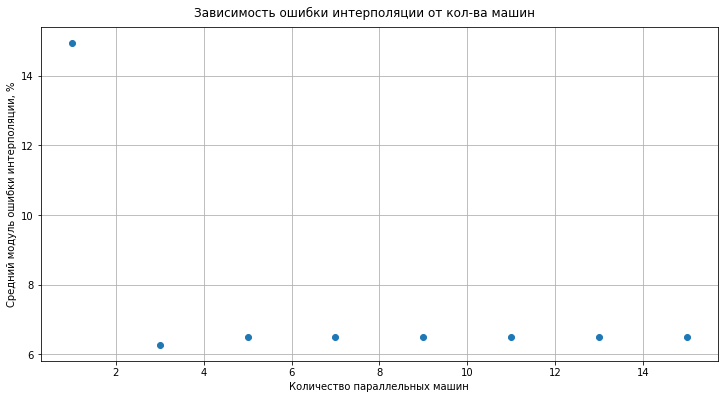

In [262]:
with open("greedyMultipleLagrange.json", 'r') as f:
    globalResults = json.load(f)
globalResults = np.array(globalResults).T
x = []
y = []
for i, res in enumerate(globalResults):
    x.append(2*i + 1)
    y.append(np.mean(np.abs(res)))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от кол-ва машин")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Количество параллельных машин")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()
pBar.value += 1

## Интерполяция Чебышева
(Два графика: эксп. точки с разным шагом)

In [257]:
N_TASKS = 25
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
global realResult
global approxResults
global s
global m
globalResults = []
for i in range(N_TASKS):
    s = TaskSet(80)
    pBar.value += 1
    results = []
    for n in range(1, 11, 1):
        m = n
        C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
        results.append((C(1.) - realResult[1])/realResult[1]*100)
    globalResults += [results]
with open("greedyMultipleChebyshev-minscale.json", 'w') as f:
    json.dump(globalResults, f)

IntProgress(value=0, max=25)

In [258]:
N_TASKS = 50
pBar = IntProgress(min=0, max=N_TASKS)
display(pBar)
global realResult
global approxResults
global s
global m
globalResults = []
for i in range(N_TASKS):
    s = TaskSet(50)
    pBar.value += 1
    results = []
    for n in range(1, 26, 2):
        m = n
        C = cheb.Chebyshev.interpolate(test_schedule, 13, [0, 2])
        results.append((C(1.) - realResult[1])/realResult[1]*100)
    globalResults += [results]
with open("greedyMultipleChebyshev.json", 'w') as f:
    json.dump(globalResults, f)

IntProgress(value=0, max=50)

**Размерность расписания:** 50

**Количество машин:** от 1 до 25 с шагом 2

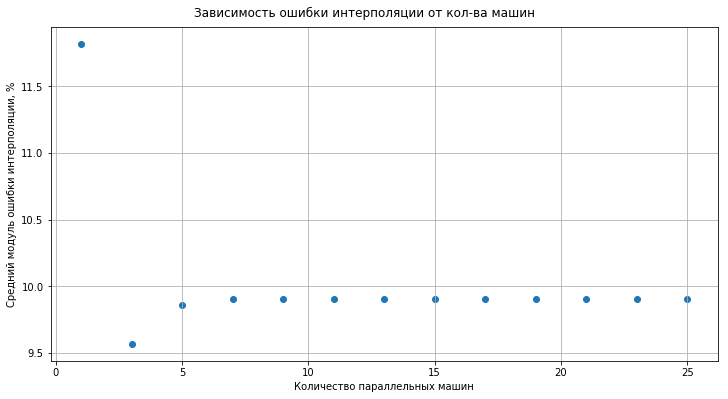

In [259]:
with open("greedyMultipleChebyshev.json", 'r') as f:
    globalResults = json.load(f)
globalResults = np.array(globalResults).T
x = []
y = []
for i, res in enumerate(globalResults):
    x.append(2*i + 1)
    y.append(np.mean(np.abs(res)))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от кол-ва машин")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Количество параллельных машин")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()
pBar.value += 1

**Размерность расписания:** 80

**Количество машин:** от 1 до 10 с шагом 1

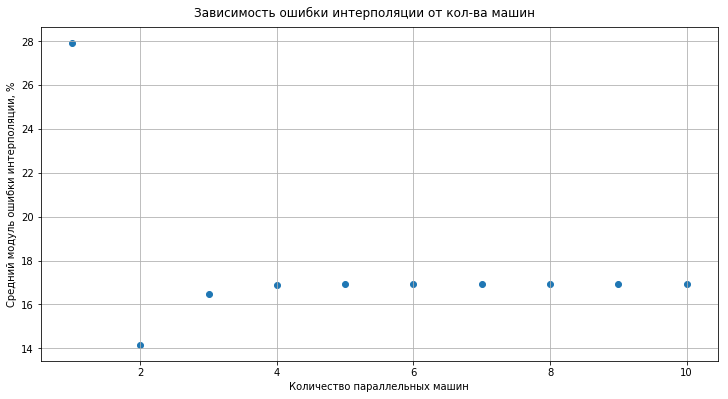

In [261]:
with open("greedyMultipleChebyshev-minscale.json", 'r') as f:
    globalResults = json.load(f)
globalResults = np.array(globalResults).T
x = []
y = []
for i, res in enumerate(globalResults):
    x.append(i + 1)
    y.append(np.mean(np.abs(res)))
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 5.5), constrained_layout=True)
fig.suptitle("Зависимость ошибки интерполяции от кол-ва машин")
axes.scatter(x, y, label="Experimental data")
#axes.plot(xp, yp, label="Interpolation")
axes.grid()
axes.set_xlabel("Количество параллельных машин")
axes.set_ylabel("Средний модуль ошибки интерполяции, %")
#axes.plot(realResult[0], realResult[1], 'ro', label="True value", alpha=0.5)
#axes.legend()
pBar.value += 1

# Итоги и выводы:
- Рассмотрены две разных реализации жадного алгоритма, выбрана наиболее эффективная (см. выше). Гипотеза: эффективность каждого из алгоритмов зависит от способа генерации примеров.
- Построены графики зависимости значения $L_{max}$ от коэффициента $\alpha$ для различного количества параллельных машин.
- Построены графики зависимости среднего модуля ошибки интерполяции от количества параллельных машин, для которых составлялись расписания.